# Segmenting and Clustering Neighborhoods in the city of Toronto

#### Import all necessary libraries:

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import beautiful soup to scrape information from website
#from bs4 import BeautifulSoup

## 1. download the data from Wikipedia

Read the table from the Wiki page as a dataframe:

In [2]:
table = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

 
 

Check the first five rows of the table:

In [3]:
df = table[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"



Check the shape of the dataframe:

In [4]:
df.shape

(180, 3)


Replace 'not assigned' to NaN, to easily remove the lines with the missing values in the next time:

In [5]:
df.replace('Not assigned', np.nan, inplace=True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [6]:
df.dropna(subset=['Borough'], inplace= True)
df.reset_index(drop=True, inplace=True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Since there is no more than one neighborhood can exist in one postal code area, and no cell has a borough but a Not assigned neighborhood, we just need to show the size of the dataframe:

In [7]:
df.shape

(103, 3)

## 2. Add longitute and latitude values to the dataframe


Geocoder not working:

In [ ]:
df['Latitude'] = ''
df['Longitute'] = ''
df.head()
#!pip install geocoder
import geocoder # import geocoder

for index, row in df.iterrows():
    postal_code = row['Postal Code']
    
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng

    row['Latitude'] = lat_lng_coords[0]
    row['Longitude'] = lat_lng_coords[1]
df.head()

Merge the table instead:

In [8]:
zipcode = pd.read_csv('http://cocl.us/Geospatial_data')
zipcode.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
df2 = df.merge(zipcode, on = 'Postal Code')
df2.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [11]:
df2.shape

(103, 5)

In [15]:
df_toronto=df2[df2['Borough'].astype(str).str.contains('Toronto')]
df_toronto.reset_index(inplace = True, drop = True)
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [16]:
#find the center of the map:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [20]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

The screenshot of the map:
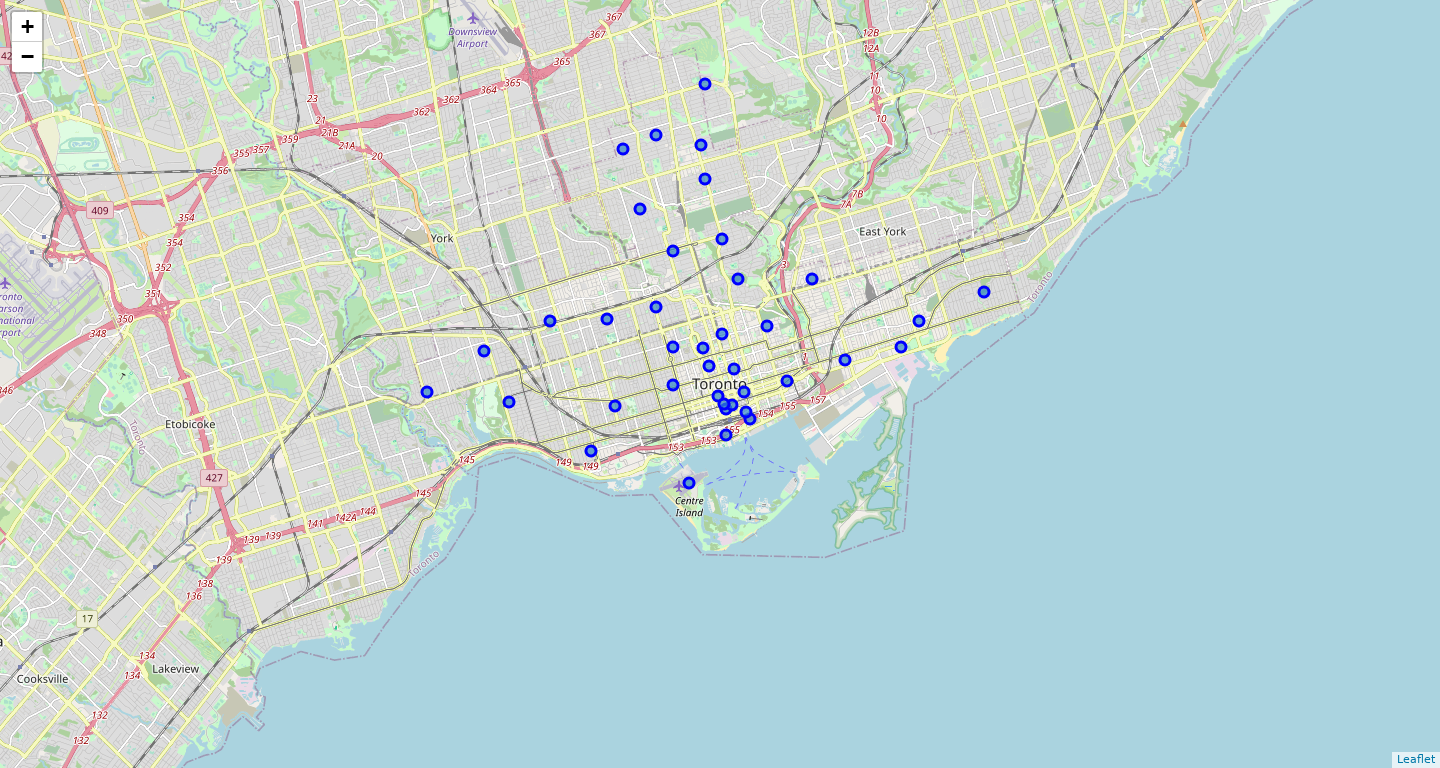

## 3. Clustering neibourhoods with k-means method

In [24]:
k_means = KMeans(init="k-means++", n_clusters=4, n_init=12)#k-means++ selects initial cluster centers for k-means clustering in a smart way to speed up convergence
Toronto_clustering = df_toronto[['Latitude','Longitude']]
Toronto_clustering.head()

,Latitude,Longitude
0,43.654260,-79.360636
1,43.662301,-79.389494
2,43.657162,-79.378937
3,43.651494,-79.375418
4,43.676357,-79.293031


In [25]:
k_means.fit(Toronto_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [26]:
k_means_labels = k_means.labels_
df_toronto.insert(0, 'Cluster Labels', k_means_labels)
k_means_labels

array([0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 1, 3, 0, 1, 3, 0, 3, 2, 2, 2, 2,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 3])

### Visualize the clusters on map:

In [32]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(9)] #number of cluster is 4, change to 9 to make colors look better
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, borough, cluster in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood'],df_toronto['Borough'], df_toronto['Cluster Labels']):
    label = folium.Popup(str(poi) + ', '+ borough +' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The screenshot of the map:

<img align="left" src="toronto_map_withclusters.png" width='800' > 